In [ ]:
import sys
sys.path.append('../')

In [2]:
import time
import os

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

## Data preparation

### Hyperparameters

In [8]:
BEST_PATH = "./models/best_MLP.h5"
LEARNING_RATE = 0.001
EPSILON = 1e-04
BATCH_SIZE = 32
N_HIDDEN = 256

### data loading

In [9]:
l = np.load('./env_set/dataset.npz')
train_input = l['train_input']
train_label = l['train_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

TIME_STEPS = l['TIME_STEPS']
OUTPUT_SIZE = l['OUTPUT_SIZE']
NUM_FEATURES = train_input.shape[-1]

In [10]:
print(train_input.shape)
print(train_label.shape)
print()
print(test_input.shape)
print(test_label.shape)

(41025, 24, 5)
(41025, 24, 5)

(16119, 24, 5)
(16119, 24, 5)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
with tf.device('/device:GPU:1'):
    mlp_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_HIDDEN, input_shape=[TIME_STEPS, NUM_FEATURES]),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dense(N_HIDDEN),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dense(test_label.shape[-1])
    ])

In [13]:
mlp_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON),
                   loss = tf.keras.losses.MeanSquaredError())
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24, 256)           1536      
_________________________________________________________________
layer_normalization (LayerNo (None, 24, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 24, 256)           65792     
_________________________________________________________________
layer_normalization_1 (Layer (None, 24, 256)           512       
_________________________________________________________________
dense_2 (Dense)              (None, 24, 5)             1285      
Total params: 69,637
Trainable params: 69,637
Non-trainable params: 0
_________________________________________________________________


In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=BEST_PATH,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [15]:
mlp_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
141/144 [============================>.] - ETA: 0s - loss: 0.0923
Epoch 00001: val_loss improved from inf to 0.01015, saving model to ./models/best_MLP.h5
144/144 [==============================] - 4s 27ms/step - loss: 0.0906 - val_loss: 0.0101
Epoch 2/150
141/144 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 00002: val_loss did not improve from 0.01015
144/144 [==============================] - 2s 13ms/step - loss: 0.0091 - val_loss: 0.0106
Epoch 3/150
142/144 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00003: val_loss did not improve from 0.01015
144/144 [==============================] - 2s 13ms/step - loss: 0.0085 - val_loss: 0.0110
Epoch 4/150
141/144 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00004: val_loss did not improve from 0.01015
144/144 [==============================] - 2s 13ms/step - loss: 0.0067 - val_loss: 0.0120
Epoch 5/150
141/144 [======================

In [16]:
test_loss = mlp_model.evaluate(test_dataset, steps=50)

print('Test Loss: {}'.format(test_loss))
#print('Test Accuracy: {}'.format(test_acc))

50/50 [==============================] - 0s 5ms/step - loss: 0.0112
Test Loss: 0.011154412366449833


In [17]:
mlp_model.save(BEST_PATH)

# Model evaluation

In [18]:
trained_model = tf.keras.models.load_model(BEST_PATH)
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24, 256)           1536      
_________________________________________________________________
layer_normalization (LayerNo (None, 24, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 24, 256)           65792     
_________________________________________________________________
layer_normalization_1 (Layer (None, 24, 256)           512       
_________________________________________________________________
dense_2 (Dense)              (None, 24, 5)             1285      
Total params: 69,637
Trainable params: 69,637
Non-trainable params: 0
_________________________________________________________________


In [19]:
np.set_printoptions(precision=6, suppress=True)

In [20]:
pred_result = trained_model.predict(test_dataset)

In [21]:
print(pred_result.shape)
print(test_label.shape)

(16119, 24, 5)
(16119, 24, 5)


In [22]:
for _ in range(test_label.shape[-1]):
    print(np.sqrt(mean_squared_error(test_label[:, :, _].reshape(-1), pred_result[:, :, _].reshape(-1))))

0.07358072160514104
0.06814283159844163
0.09811075546204696
0.052522488554427864
0.15546428717170932


In [23]:
r2 = RSquare()
for _ in range(test_label.shape[-1]):
    r2.reset_states()
    print(r2(tf.cast(test_label[:, :, _].reshape(-1), tf.float32), tf.cast(pred_result[:, :, _].reshape(-1), tf.float32)))

tf.Tensor(0.71912956, shape=(), dtype=float32)
tf.Tensor(0.8330394, shape=(), dtype=float32)
tf.Tensor(0.71043587, shape=(), dtype=float32)
tf.Tensor(0.4728542, shape=(), dtype=float32)
tf.Tensor(0.6153047, shape=(), dtype=float32)


In [24]:
((MAXS-MINS)*test_label + MINS).shape

(16119, 24, 5)

[10, 40, 10, 40]

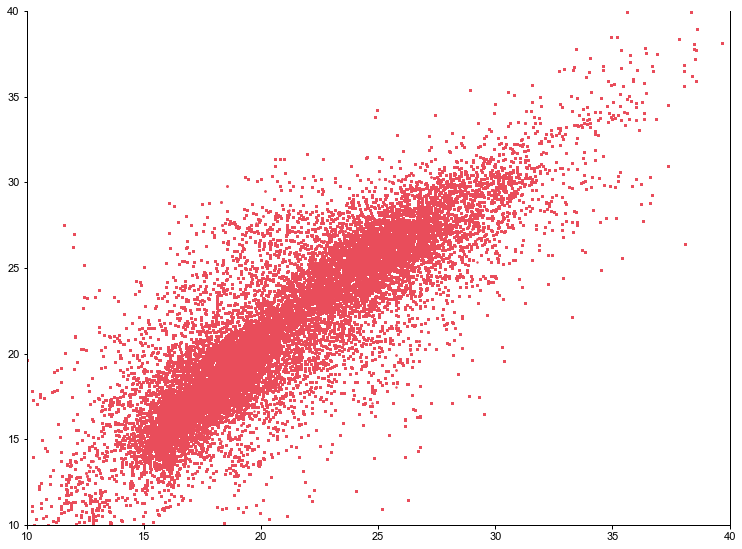

In [25]:
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))
x = np.arange(0,2)
plt.plot(x, x, 'k')
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*pred_result + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2
           )
plt.axis([10,40,10,40])
#plt.plot(x, tf.nn.softmax(logit[0][0, 5, :]).numpy(), c=cmap[0], alpha=0.2)
#plt.plot(x, tf.nn.softmax(logit[0][0, -1, :]).numpy(), c=cmap[3], alpha=0.2)

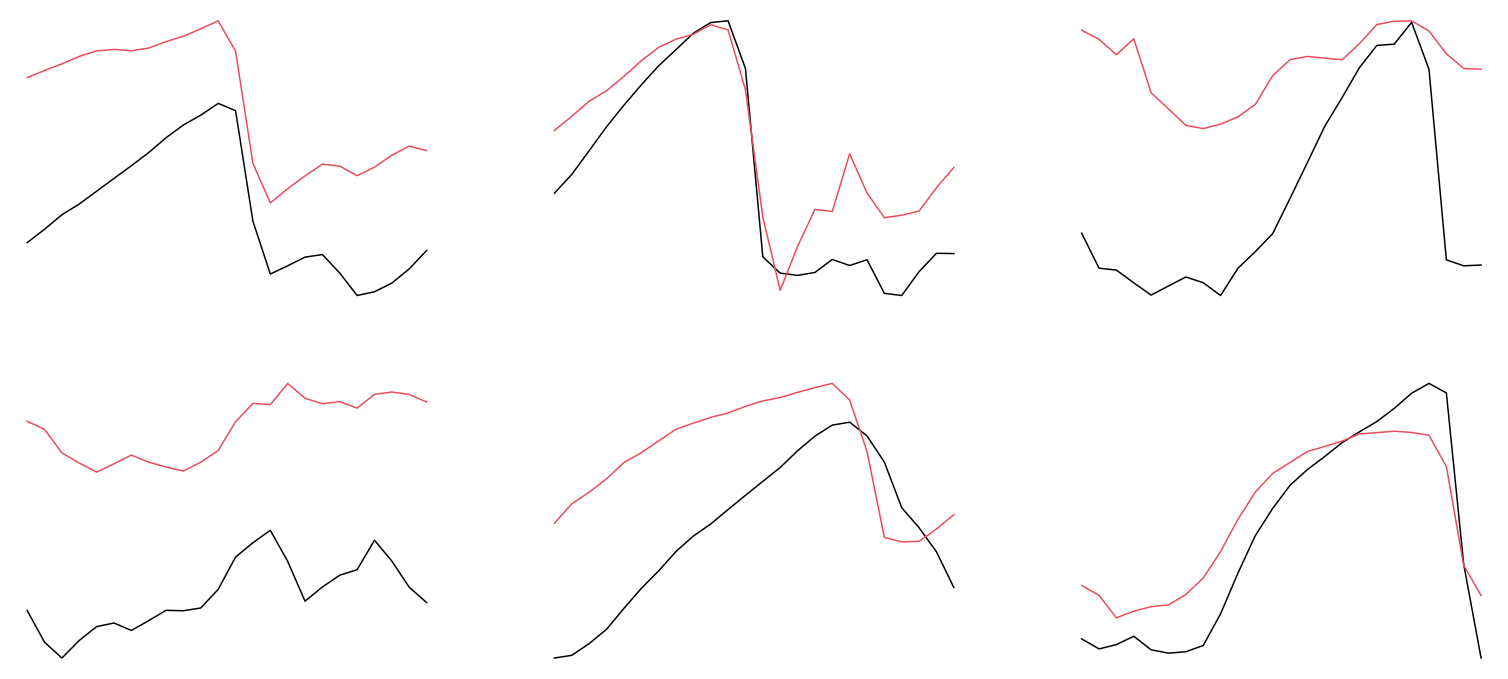

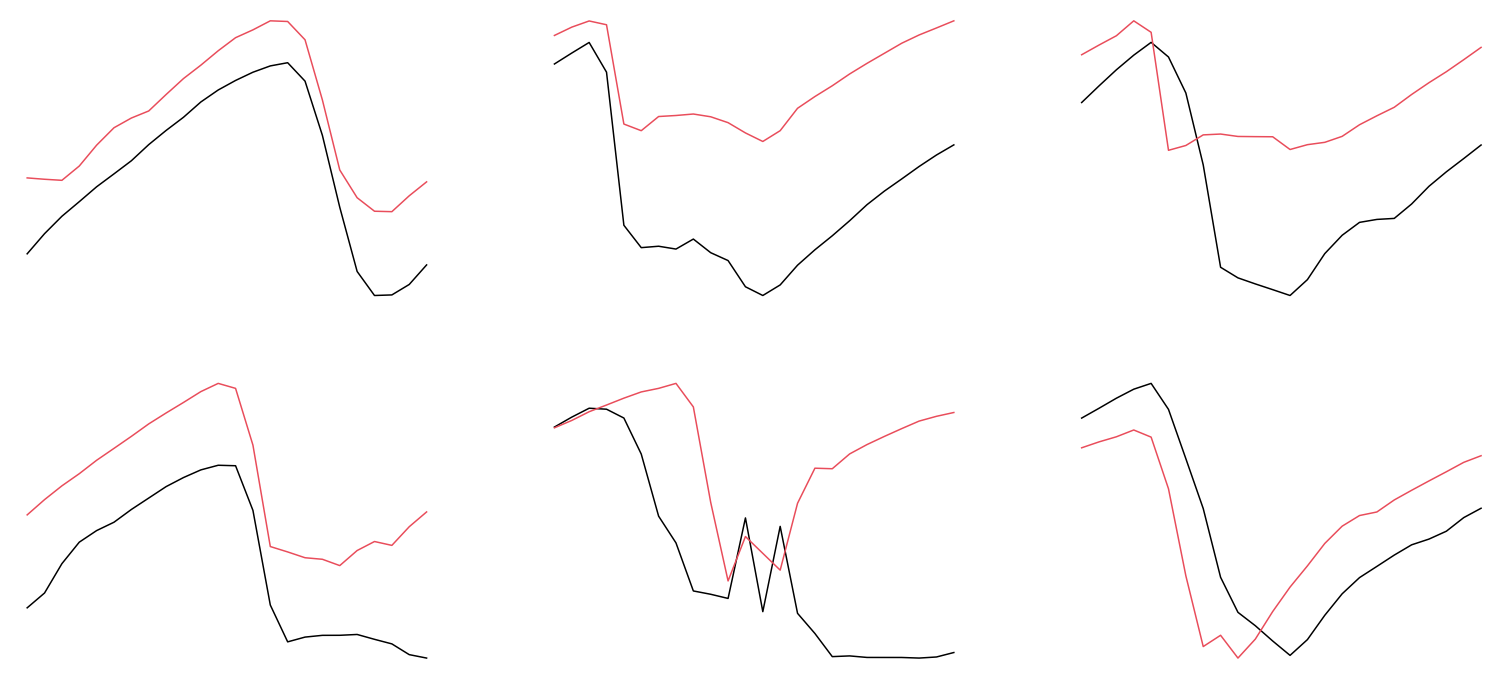

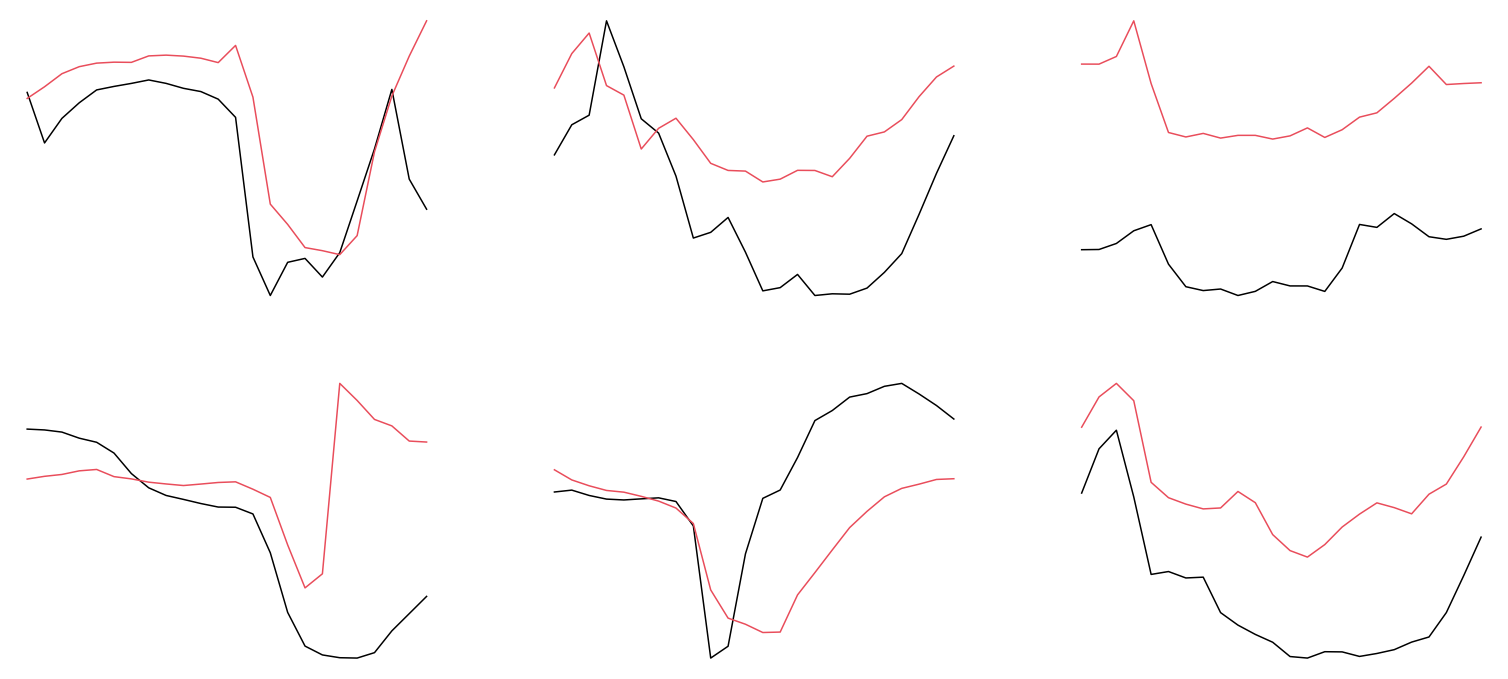

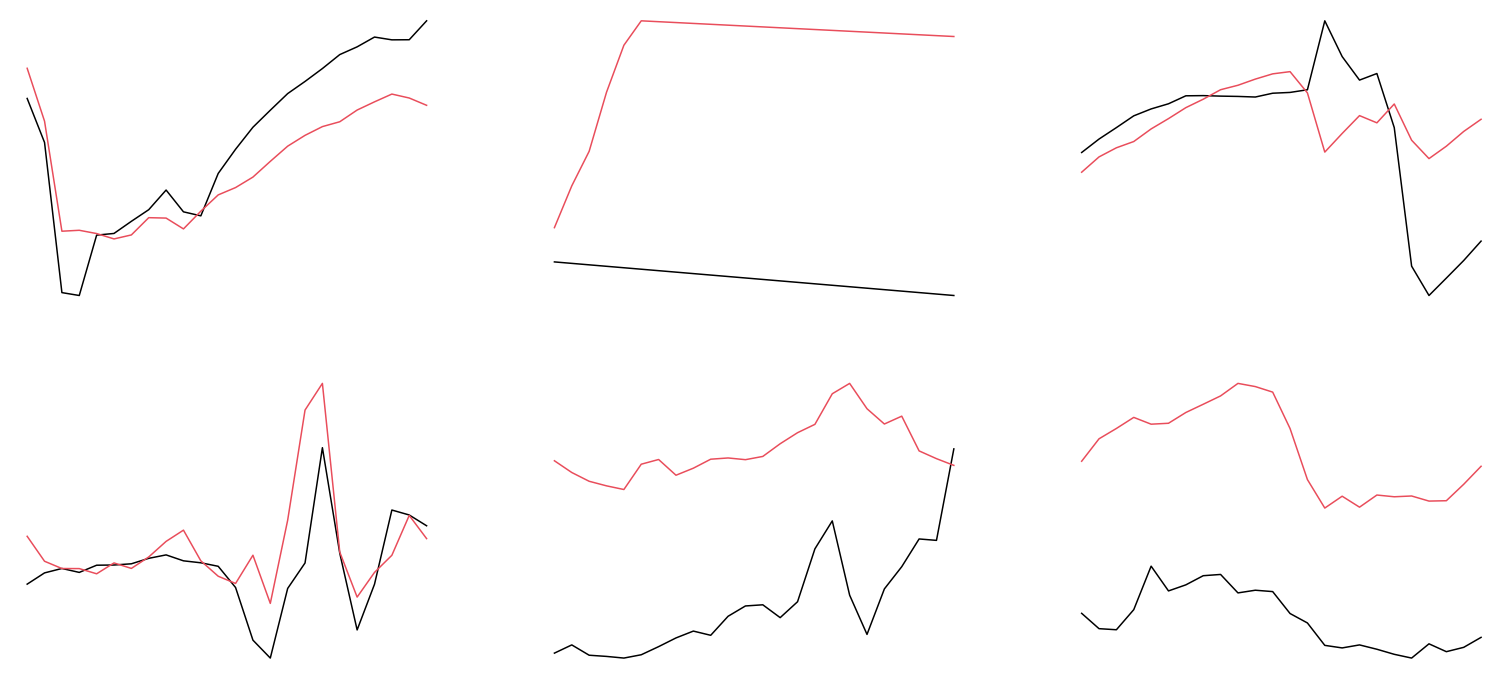

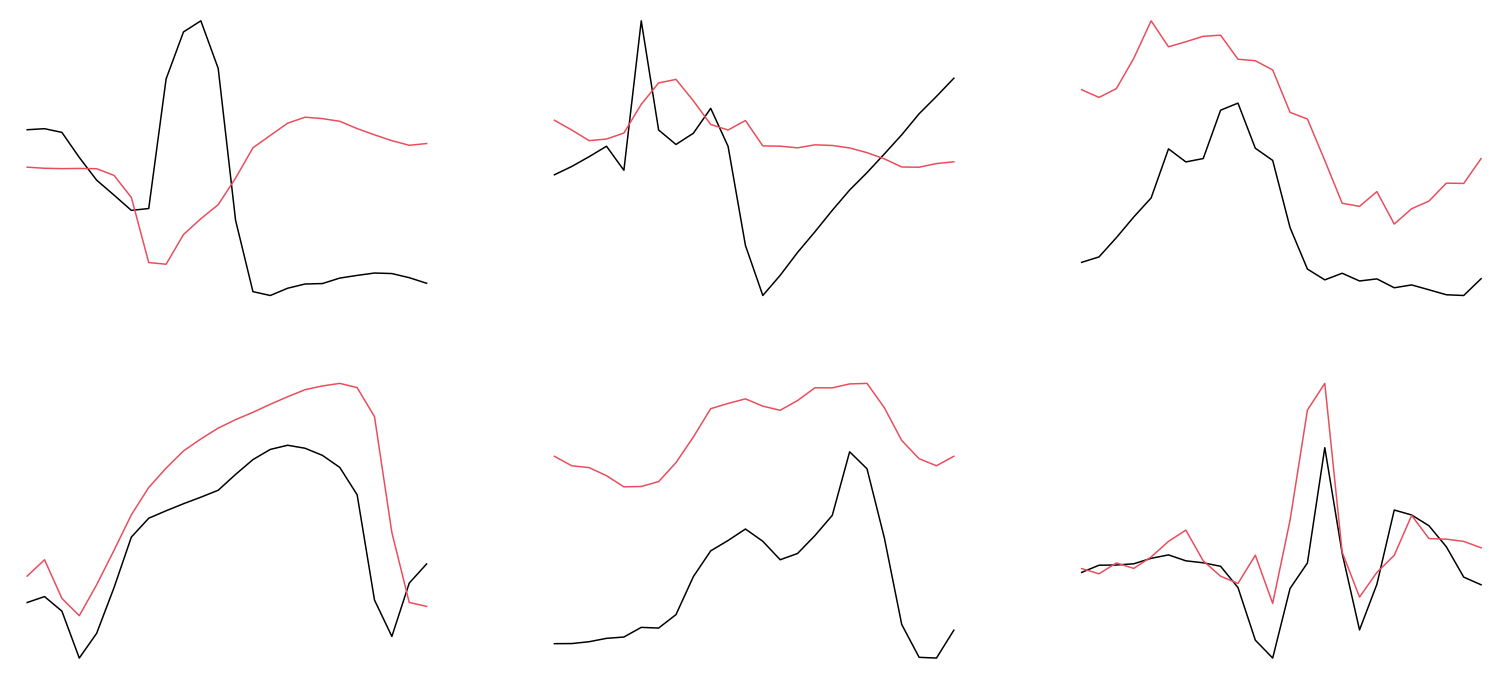

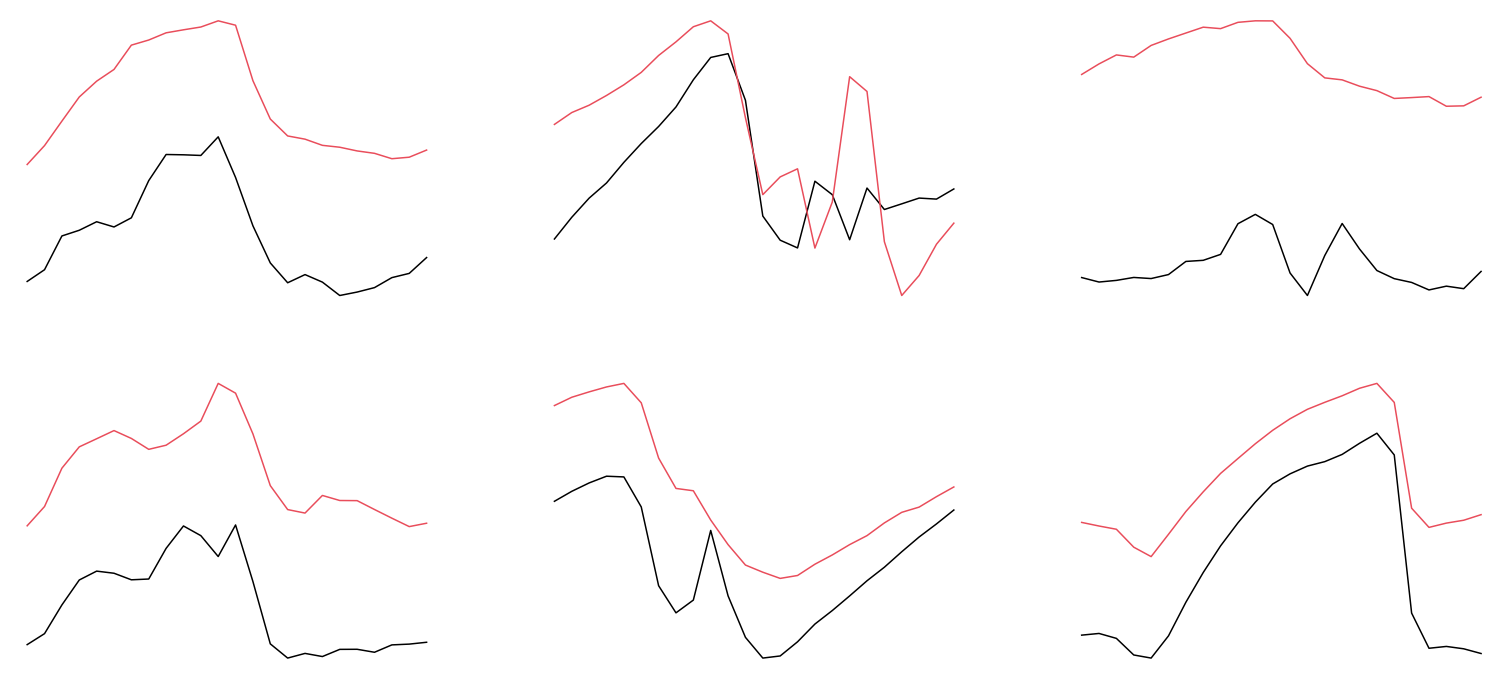

In [26]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, pred_result.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*8, (6/2.54)*8))
        
        i=-2
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #black
            expect1 = plt.plot(x_t, pred_result[NUMBER, :, i], c=cmap[0], alpha=1) #red
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1